<a href="https://colab.research.google.com/github/RyutoYoda/Titanic_LightGBM/blob/main/Titanic_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os 
os.chdir('/content/drive/MyDrive/TUコンペ') 

In [5]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [14]:
# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [15]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [16]:
train = train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [17]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)

In [18]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

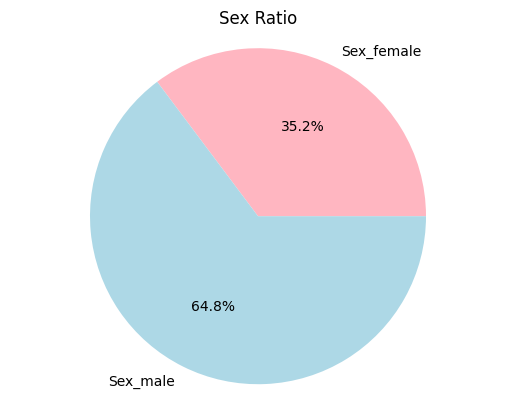

In [20]:
import matplotlib.pyplot as plt

# 性別の割合を計算
sex_ratios = train[['Sex_female', 'Sex_male']].mean()

# グラフの描画
labels = sex_ratios.index
sizes = sex_ratios.values
colors = ['lightpink', 'lightblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sex Ratio')
plt.show()


In [21]:
# テストデータに'Embarked_0'列を追加
test['Embarked_0'] = 0

In [22]:
# 学習データの列の順序を修正する
train = train[['PassengerId','Perished', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_0', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]

# テストデータの列の順序を修正する
test = test[['PassengerId','Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_0','Embarked_C', 'Embarked_Q', 'Embarked_S']]


In [23]:
X = train.drop('Perished', axis=1)
y = train['Perished']

In [24]:
# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# LightGBMのデータセットに変換
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val)

In [26]:
# LightGBMのハイパーパラメータの設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 45
}

In [ ]:
# LightGBMモデルの学習
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset], early_stopping_rounds=100, verbose_eval=20)

In [28]:
y_pred = model.predict(X_val)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

In [29]:
# 精度の評価
accuracy = accuracy_score(y_val, y_pred_binary)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8379888268156425


In [30]:
# テストデータの予測
test_pred = model.predict(test)
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_pred]

In [31]:
# 予測結果の保存
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Perished': test_pred_binary})
submission.to_csv('/content/drive/MyDrive/TUコンペ/submission.csv', index=False)
